In [1]:
# !pip install sentence-transformers

In [2]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import pandas as pd
from sentence_transformers import SentenceTransformer, util

In [3]:
df = pd.read_excel('DLT-Test-Clean.xlsx')

In [4]:
df.head()
print(df.shape)

(98, 3)


### Between train and test datasets

In [5]:
file_path = 'train-00000-of-00001-5cdebbc48da41394.parquet'
train_df = pd.read_parquet(file_path)

In [6]:
train_df.head()
print(train_df.shape)

(1260, 5)


In [7]:
train_df.rename(columns={'question': 'Question', 'answer': 'Actual Answer'}, inplace=True)
train_df['Source'] = 'Train'
df['Source'] = 'Test'

combined_df = pd.concat([train_df[['Question', 'Actual Answer', 'Source']], 
                         df[['Question', 'Actual Answer', 'Source']]], ignore_index=True)
vectorizer = TfidfVectorizer()
tfidf_matrix = vectorizer.fit_transform(combined_df['Question'])
tfidf_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)

model = SentenceTransformer('bert-base-nli-mean-tokens')
embeddings = model.encode(combined_df['Question'], convert_to_tensor=True)
bert_sim = util.cos_sim(embeddings, embeddings).numpy()

similar_pairs = []
num_questions = len(combined_df)
for i in range(num_questions):
    for j in range(i+1, num_questions):
        # TODO: Remove the condition below as we don't want to filter out test questions
        # if tfidf_sim[i, j] >= tfidf_threshold and bert_sim[i, j] >= bert_threshold:
        if combined_df['Source'][i] != combined_df['Source'][j]:
            pair_info = {
                "Question 1": combined_df['Question'][i],
                "Source 1": combined_df['Source'][i],
                "Answer 1": combined_df['Actual Answer'][i],
                "Question 2": combined_df['Question'][j],
                "Source 2": combined_df['Source'][j],
                "Answer 2": combined_df['Actual Answer'][j],
                "TF-IDF Similarity": tfidf_sim[i, j],
                "BERT Similarity": bert_sim[i, j]
            }
            similar_pairs.append(pair_info)


similar_pairs_df = pd.DataFrame(similar_pairs)

In [8]:
print(similar_pairs_df.describe())
display(similar_pairs_df.head())

       TF-IDF Similarity  BERT Similarity
count      123480.000000    123480.000000
mean            0.046161         0.565576
std             0.054505         0.140689
min             0.000000        -0.126579
25%             0.009618         0.484258
50%             0.030902         0.586537
75%             0.062541         0.665408
max             0.960586         1.000000


,Question 1,Source 1,Answer 1,Question 2,Source 2,Answer 2,TF-IDF Similarity,BERT Similarity
0,How can I evaluate the performance and quality...,Train,There are several metrics that can be used to ...,What programming languages or frameworks does ...,Test,Lamini currently has support in python and a R...,0.006114,0.724542
1,How can I evaluate the performance and quality...,Train,There are several metrics that can be used to ...,Does Lamini AI provide any features for genera...,Test,"No, Lamini AI does not provide any features fo...",0.031293,0.717492
2,How can I evaluate the performance and quality...,Train,There are several metrics that can be used to ...,What are the possible causes of Internal Serve...,Test,Internal server errors are usually caused by a...,0.064759,0.428229
3,How can I evaluate the performance and quality...,Train,There are several metrics that can be used to ...,Are there any hyperparameter tuning options av...,Test,Lamini is a powerful engine used to fine-tunin...,0.208471,0.641683
4,How can I evaluate the performance and quality...,Train,There are several metrics that can be used to ...,How does the performance of LLMs trained using...,Test,"According to the information provided, Lamini ...",0.212091,0.800454


In [10]:
train_test_pairs_df = similar_pairs_df[(similar_pairs_df['Source 1'] == 'Train') & (similar_pairs_df['Source 2'] == 'Test')]
print(train_test_pairs_df.shape)

# Group by 'Question 2' and get the index of the max 'BERT Similarity' for each group
most_similar_idx = train_test_pairs_df.groupby('Question 2')['BERT Similarity'].idxmax()

# Create a DataFrame of the most similar pairs
most_similar_pairs_df = train_test_pairs_df.loc[most_similar_idx]
print(most_similar_pairs_df.shape)

(123480, 8)
(98, 8)


In [21]:
list(train_test_pairs_df['Question 2'].head())

['What programming languages or frameworks does Lamini support? Do I need to have expertise in a specific language to use it effectively?',
 'Does Lamini AI provide any features for generating text in different writing styles, such as academic, journalistic, or persuasive?',
 'What are the possible causes of Internal Server 500 errors in Lamini Python package?',
 'Are there any hyperparameter tuning options available in Lamini to optimize the performance of customized models?',
 'How does the performance of LLMs trained using Lamini compare to models fine-tuned with traditional approaches?']

In [28]:
a = train_test_pairs_df[train_test_pairs_df['Question 2'] == 'What programming languages or frameworks does Lamini support? Do I need to have expertise in a specific language to use it effectively?'].sort_values(by='BERT Similarity', ascending=False)
display(a.iloc[0,:])

Question 1           Does Lamini support code completion for specif...
Source 1                                                         Train
Answer 1             Yes, if you have example data in different lan...
Question 2           What programming languages or frameworks does ...
Source 2                                                          Test
Answer 2             Lamini currently has support in python and a R...
TF-IDF Similarity                                             0.356159
BERT Similarity                                               0.925318
Name: 13524, dtype: object

In [11]:
comparison_data = []

for index, row in most_similar_pairs_df.iterrows():
    question_2 = row['Question 2']
    answer_1 = row['Answer 1']
    answer_2 = row['Answer 2']
    generated_answer = df[df['Question'] == question_2]['Generated Answer'].values[0]
    bert_similarity_q1_q2 = row['BERT Similarity'] 

    # TF-IDF Vectorization and Cosine Similarity Calculation
    tfidf_vectorizer = TfidfVectorizer()
    tfidf_matrix = tfidf_vectorizer.fit_transform([answer_1, answer_2, generated_answer])
    tfidf_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)

    # BERT Embeddings Generation
    bert_embeddings = model.encode([answer_1, answer_2, generated_answer], convert_to_tensor=True)
    bert_sim = util.cos_sim(bert_embeddings, bert_embeddings).numpy()

    # Term Overlap Calculation
    answer_1_terms = set(answer_1.split())
    answer_2_terms = set(answer_2.split())
    generated_answer_terms = set(generated_answer.split())
    overlap_1 = len(answer_1_terms.intersection(generated_answer_terms)) / len(answer_1_terms.union(generated_answer_terms))
    overlap_2 = len(answer_2_terms.intersection(generated_answer_terms)) / len(answer_2_terms.union(generated_answer_terms))

    # Append the data
    comparison_data.append({
        'Question 2': question_2,
        'Answer 1': answer_1,
        'Answer 2': answer_2,
        'Generated Answer': generated_answer,
        'BERT Similarity Q1-Q2': bert_similarity_q1_q2,
        'TF-IDF Similarity (Answer 1)': tfidf_sim[0, 2],
        'TF-IDF Similarity (Answer 2)': tfidf_sim[1, 2],
        'BERT Similarity (Answer 1)': bert_sim[0, 2],
        'BERT Similarity (Answer 2)': bert_sim[1, 2],
        'Term Overlap (Answer 1)': overlap_1,
        'Term Overlap (Answer 2)': overlap_2
    })

comparison_df = pd.DataFrame(comparison_data)

In [12]:
# Define a function to tokenize a text into terms
def tokenize(text):
    return set(text.lower().split())

# Initialize new columns
comparison_df['Unique Terms (Answer 2)'] = 0
comparison_df['Unique Terms (Generated Answer)'] = 0
comparison_df['Terms in Answer 2 not in Generated Answer'] = None
comparison_df['Terms in Generated Answer not in Answer 2'] = None

# Iterate through each row
for index, row in comparison_df.iterrows():
    # Tokenize Answer 2 and Generated Answer
    answer_2_terms = tokenize(row['Answer 2'])
    generated_answer_terms = tokenize(row['Generated Answer'])

    # Count unique terms
    comparison_df.at[index, 'Unique Terms (Answer 2)'] = len(answer_2_terms)
    comparison_df.at[index, 'Unique Terms (Generated Answer)'] = len(generated_answer_terms)

    # Find terms difference
    comparison_df.at[index, 'Terms in Answer 2 not in Generated Answer'] = list(answer_2_terms - generated_answer_terms)
    comparison_df.at[index, 'Terms in Generated Answer not in Answer 2'] = list(generated_answer_terms - answer_2_terms)

In [13]:
comparison_df.head()

,Question 2,Answer 1,Answer 2,Generated Answer,BERT Similarity Q1-Q2,TF-IDF Similarity (Answer 1),TF-IDF Similarity (Answer 2),BERT Similarity (Answer 1),BERT Similarity (Answer 2),Term Overlap (Answer 1),Term Overlap (Answer 2),Unique Terms (Answer 2),Unique Terms (Generated Answer),Terms in Answer 2 not in Generated Answer,Terms in Generated Answer not in Answer 2
0,\n,"Did you type something, I am having trouble un...","Did you type something, I am having trouble un...","I am a Lamini Bot, I am here to help you with ...",1.000000,0.129183,0.129183,0.362989,0.362989,0.166667,0.166667,9,12,"[something,, understanding, did, trouble, havi...","[with, here, related, to, lamini, a, bot,, que..."
1,Are there any code samples illustrating how to...,"Yes, there is a separate section in the docume...","Yes, there is a separate section in the docume...","Yes, there are code samples illustrating how t...",0.910099,0.154310,0.154310,0.598289,0.598289,0.103448,0.103448,16,76,"[more, authentication,, https://lamini-ai.gith...","[their, them, lamini, developer, system, overa..."
2,Are there any code samples illustrating how to...,To look at the code samples Lamini provides in...,"Yes, the Python logging module documentation p...",There is no information in Lamini’s python lib...,0.876445,0.275727,0.455935,0.655294,0.775220,0.090090,0.142857,23,88,"[here:, provides, yes,, https://docs.python.or...","[handlers,, mind, you’d, try, needs, however,,..."
3,Are there any examples of using Lamini for que...,All our tutorials and walkthroughs are availab...,"Yes, there is an example of using Lamini for q...","Yes, there are several examples of using Lamin...",0.838847,0.165446,0.469282,0.703876,0.772940,0.152941,0.208791,56,53,"[tasks, in, then, class, class., ""test_create_...","[demonstrate, available, step-by-step, lamini""..."
4,Are there any guidelines or recommendations on...,"Yes, there are some specific considerations an...",There are no specific guidelines or recommenda...,"Yes, there are guidelines and recommendations ...",0.888517,0.516537,0.799248,0.820108,0.603878,0.216867,0.375000,48,48,"[numbers, available., different, use, experime...","[desired, during, level, increase, adjust, dat..."


In [16]:
comparison_df.to_csv('Updated Comparison Data.csv', index=False)

### Plots

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns

c:\Users\porwa\miniconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\porwa\miniconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\porwa\miniconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\porwa\miniconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is

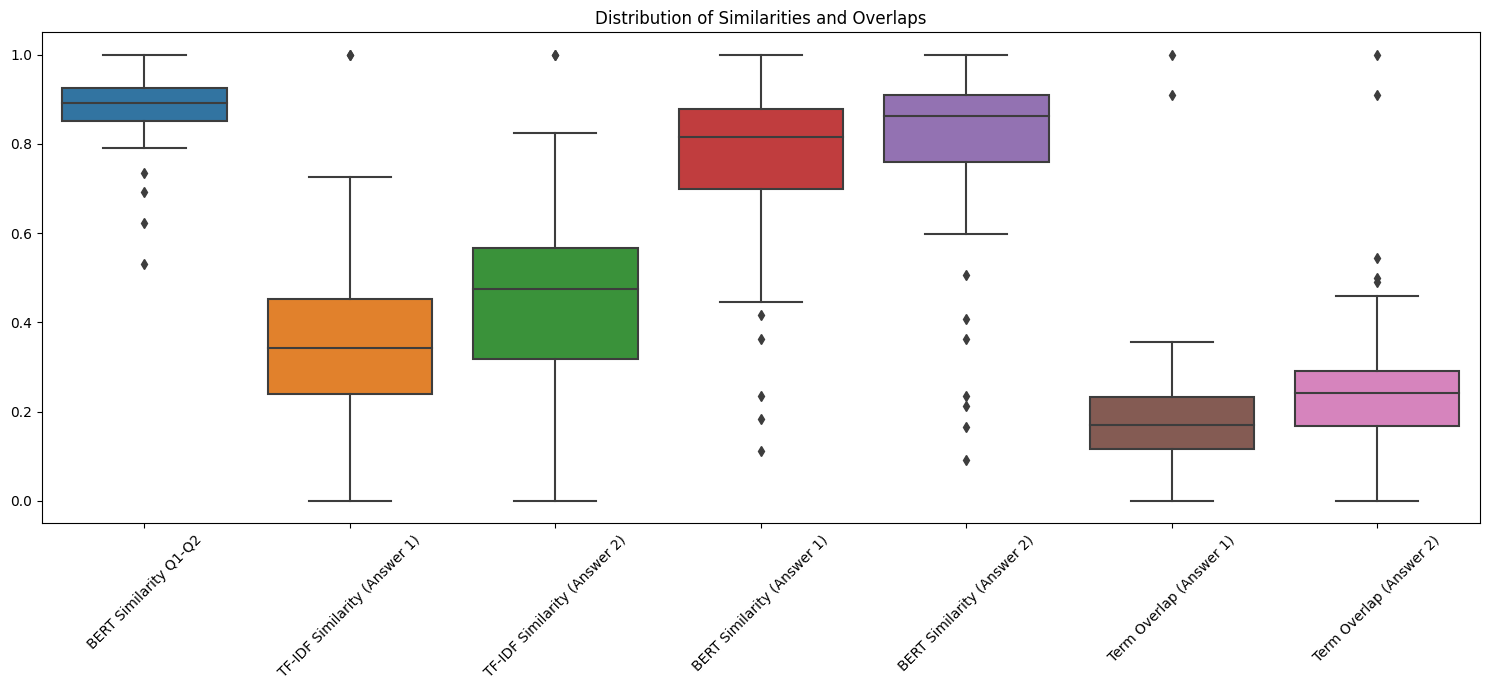

c:\Users\porwa\miniconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\porwa\miniconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


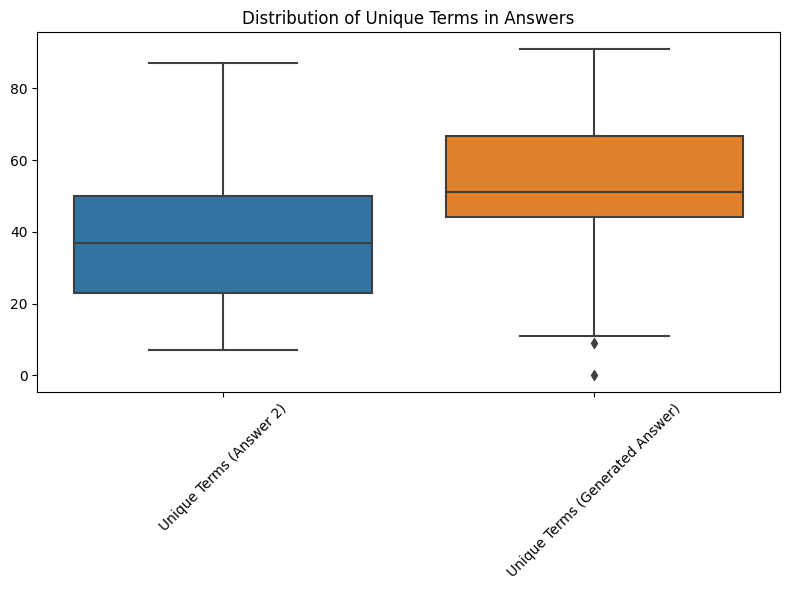

In [19]:
# Boxplot for similarity and overlap metrics
plt.figure(figsize=(15, 7))
sns.boxplot(data=comparison_df[['BERT Similarity Q1-Q2', 'TF-IDF Similarity (Answer 1)', 
                                'TF-IDF Similarity (Answer 2)', 'BERT Similarity (Answer 1)', 
                                'BERT Similarity (Answer 2)', 'Term Overlap (Answer 1)', 
                                'Term Overlap (Answer 2)']])
plt.title('Distribution of Similarities and Overlaps')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Boxplot for unique terms
plt.figure(figsize=(8, 6))
sns.boxplot(data=comparison_df[['Unique Terms (Answer 2)', 'Unique Terms (Generated Answer)']])
plt.title('Distribution of Unique Terms in Answers')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [30]:
comparison_df['BERT Similarity Q1-Q2 Bin'].value_counts()

BERT Similarity Q1-Q2 Bin
4    20
0    20
2    20
3    19
1    19
Name: count, dtype: int64

c:\Users\porwa\miniconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\porwa\miniconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\porwa\miniconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\porwa\miniconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is

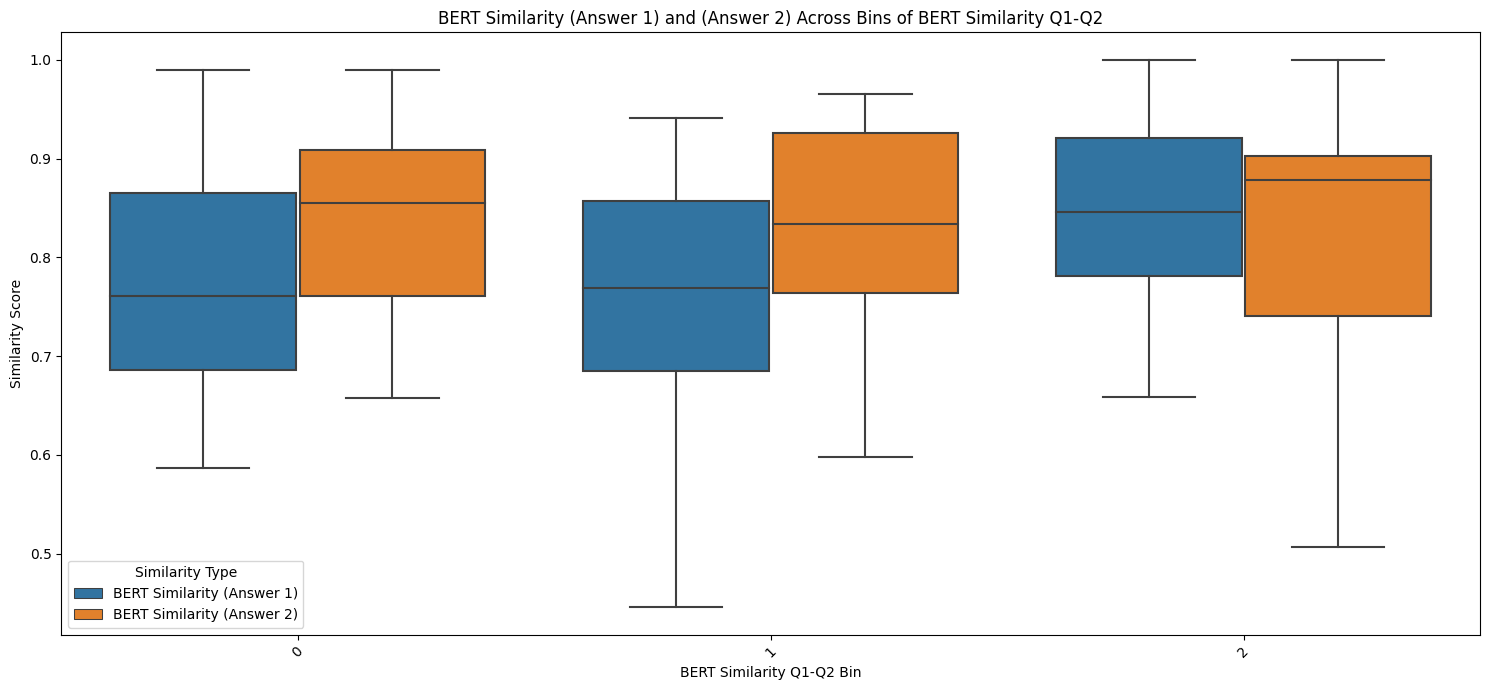

In [39]:
comparison_df['BERT Similarity Q1-Q2 Bin'] = pd.qcut(comparison_df['BERT Similarity Q1-Q2'], q=3, labels=False)

plot_data = pd.melt(comparison_df, id_vars=['BERT Similarity Q1-Q2 Bin'], 
                    value_vars=['BERT Similarity (Answer 1)', 'BERT Similarity (Answer 2)'],
                    var_name='Similarity Type', value_name='Similarity Score')

plt.figure(figsize=(15, 7))
sns.boxplot(x='BERT Similarity Q1-Q2 Bin', y='Similarity Score', hue='Similarity Type', data=plot_data, showfliers=False)
plt.title('BERT Similarity (Answer 1) and (Answer 2) Across Bins of BERT Similarity Q1-Q2')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

c:\Users\porwa\miniconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\porwa\miniconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\porwa\miniconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\porwa\miniconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with

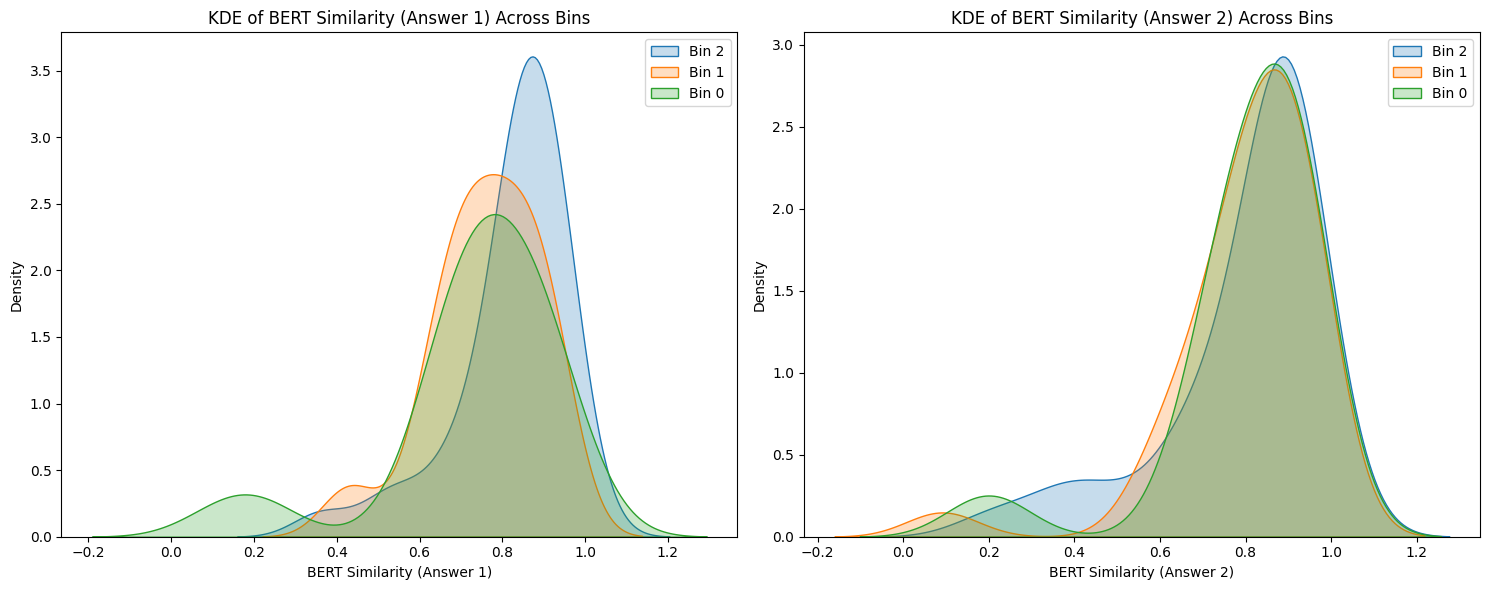

In [40]:
plt.figure(figsize=(15, 6))

plt.subplot(1, 2, 1)
for bin_num in comparison_df['BERT Similarity Q1-Q2 Bin'].unique():
    sns.kdeplot(data=comparison_df[comparison_df['BERT Similarity Q1-Q2 Bin'] == bin_num], 
                x='BERT Similarity (Answer 1)', label=f'Bin {bin_num}', fill=True)
plt.title('KDE of BERT Similarity (Answer 1) Across Bins')
plt.legend()

plt.subplot(1, 2, 2)
for bin_num in comparison_df['BERT Similarity Q1-Q2 Bin'].unique():
    sns.kdeplot(data=comparison_df[comparison_df['BERT Similarity Q1-Q2 Bin'] == bin_num], 
                x='BERT Similarity (Answer 2)', label=f'Bin {bin_num}', fill=True)
plt.title('KDE of BERT Similarity (Answer 2) Across Bins')
plt.legend()

plt.tight_layout()
plt.show()